# Solving the Reacher environment using DDPG
---

### Import the necessary packages

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from continuous_control.agent import Agent

### Instantiate the environment

In [2]:
env = UnityEnvironment(file_name='Reacher/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Instantiate the agent

In [3]:
# get the default brain (the interface for the agent)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# create a new agent
agent = Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size, random_seed=2)

### Train the agent using the DDPG algorithm

In [4]:
def ddpg(n_episodes=10000, max_t=3000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    beta = 0.1  # factor the random noise gets multiplied with
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  # get the current states
        e_scores = np.zeros(20)  # the scores of an episode for each of the 20 reachers
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, noise_factor=beta)# let the agent select actions
            env_info = env.step(actions)[brain_name]      # execute the selected actions and save the new information about the environment
            rewards = env_info.rewards                    # get the rewards
            next_states = env_info.vector_observations    # get the resulting states
            dones = env_info.local_done                   # check whether episodes have finished
            agent.step(states, actions, rewards, next_states, dones)  # pass the information to the agent
            states = next_states
            e_scores += rewards
            if np.any(dones):
                break 
        avg_score = np.mean(e_scores)  # the average score of the agents
        scores_deque.append(avg_score)
        scores.append(avg_score)
        beta = max(0.995 * beta, 0.01)  # reduce the noise a bit while training
        print('\rEpisode {:d}\tscore: {:.2f}\taverage score over the last 10 episodes: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(list(scores_deque)[-10:])), end="")
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
        if i_episode > 100 and np.mean(scores_deque) > 30:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = ddpg()
env.close()  # close the environment as it is no longer needed

Episode 100	Average Score: 3.96
Episode 200	Average Score: 24.12
Episode 233	score: 33.83	average score over the last 10 episodes: 33.87
Environment solved in 133 episodes!	Average Score: 30.11


### Plot the scores

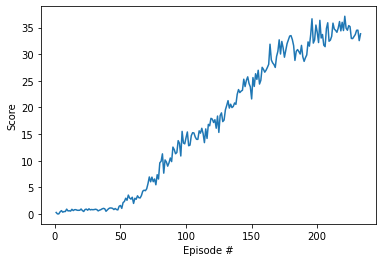

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()